In [51]:
# !rm -r autonomous_car_driving
!git clone https://github.com/sharathrjtr/autonomous_car_driving.git
!ls autonomous_car_driving/track_train_data

fatal: destination path 'autonomous_car_driving' already exists and is not an empty directory.
driving_log.csv  IMG


In [52]:
!pip install imgaug

In [0]:
import numpy as np
import os
import ntpath
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import random

In [54]:
datadir = 'autonomous_car_driving/track_train_data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  ...     speed
0  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_56_903.jpg  ...  0.000078
1  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_57_008.jpg  ...  0.000078
2  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_57_110.jpg  ...  0.000079
3  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_57_212.jpg  ...  0.000079
4  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_57_321.jpg  ...  0.000080

[5 rows x 7 columns]

In [55]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2019_08_25_21_17_56_903.jpg  ...  0.000078
1  center_2019_08_25_21_17_57_008.jpg  ...  0.000078
2  center_2019_08_25_21_17_57_110.jpg  ...  0.000079
3  center_2019_08_25_21_17_57_212.jpg  ...  0.000079
4  center_2019_08_25_21_17_57_321.jpg  ...  0.000080

[5 rows x 7 columns]

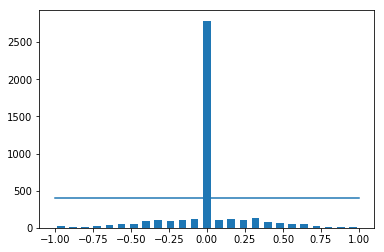

In [56]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:])/2
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data:  4254
removed:  2388
remaining:  1866


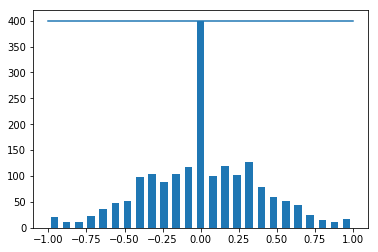

In [57]:
print('total data: ', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] < bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [58]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path=[]
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    
    # center image append
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir+'/IMG', data)

center      center_2019_08_25_21_17_58_463.jpg
left        left_2019_08_25_21_17_58_463.jpg  
right       right_2019_08_25_21_17_58_463.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.88763e-05                       
Name: 15, dtype: object


In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(str(len(X_train)), str(len(X_valid))))

print(X_train[0])
print(image_paths[0])

Training Samples: 4478
Valid Samples: 1120
autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_22_39_754.jpg
autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_57_728.jpg


Text(0.5, 1.0, 'Validation set')

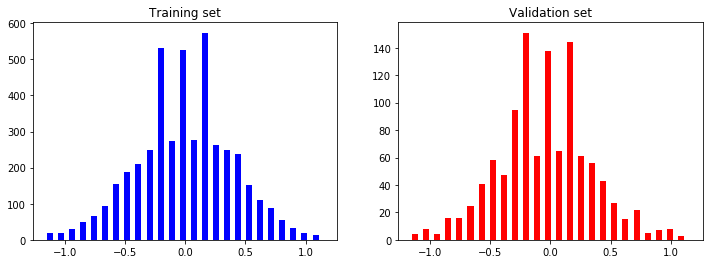

In [60]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
ax[0].set_title('Training set')
ax[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
ax[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

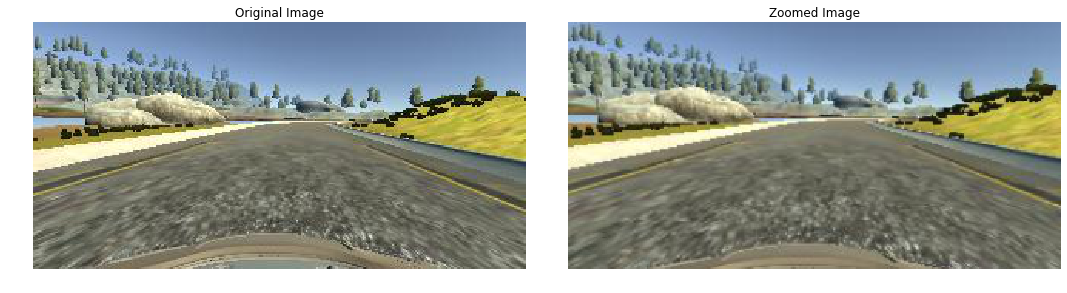

In [62]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(zoomed_image)
axes[1].axis('off')
axes[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1, 0.1), "y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

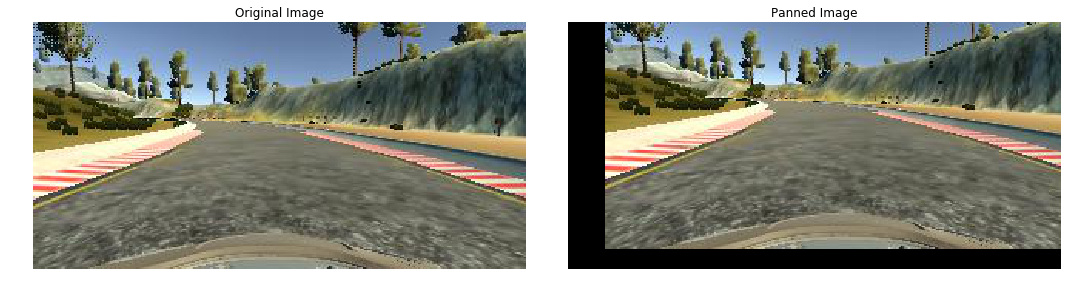

In [64]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(panned_image)
axes[1].axis('off')
axes[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

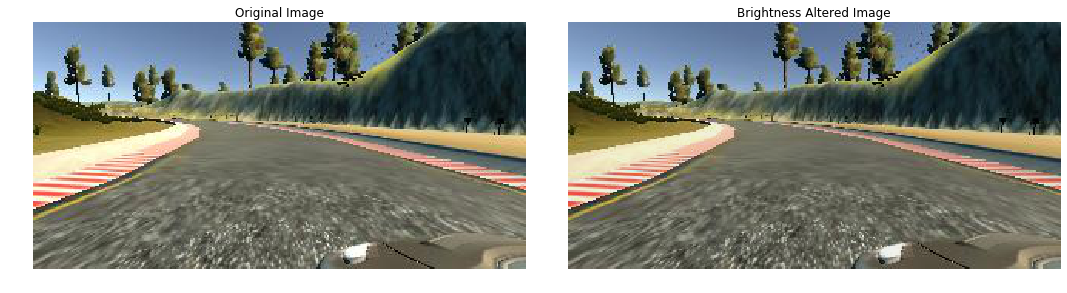

In [66]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(brightness_altered_image)
axes[1].axis('off')
axes[1].set_title('Brightness Altered Image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1) #0: vertical flip, 1: horizontal flip, -1: combination of vertical and horizontal flip
  steering_angle = -1*steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle: -0.0')

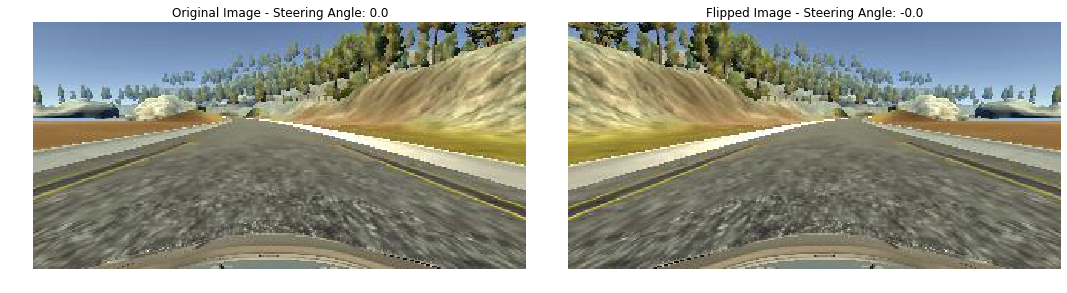

In [68]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)

flipped_image, steering_angle_flip = img_random_flip(original_image, steering_angle)


fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image - '+'Steering Angle: ' + str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].axis('off')
axes[1].set_title('Flipped Image - '+'Steering Angle: ' + str(steering_angle_flip))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
    
  return image, steering_angle

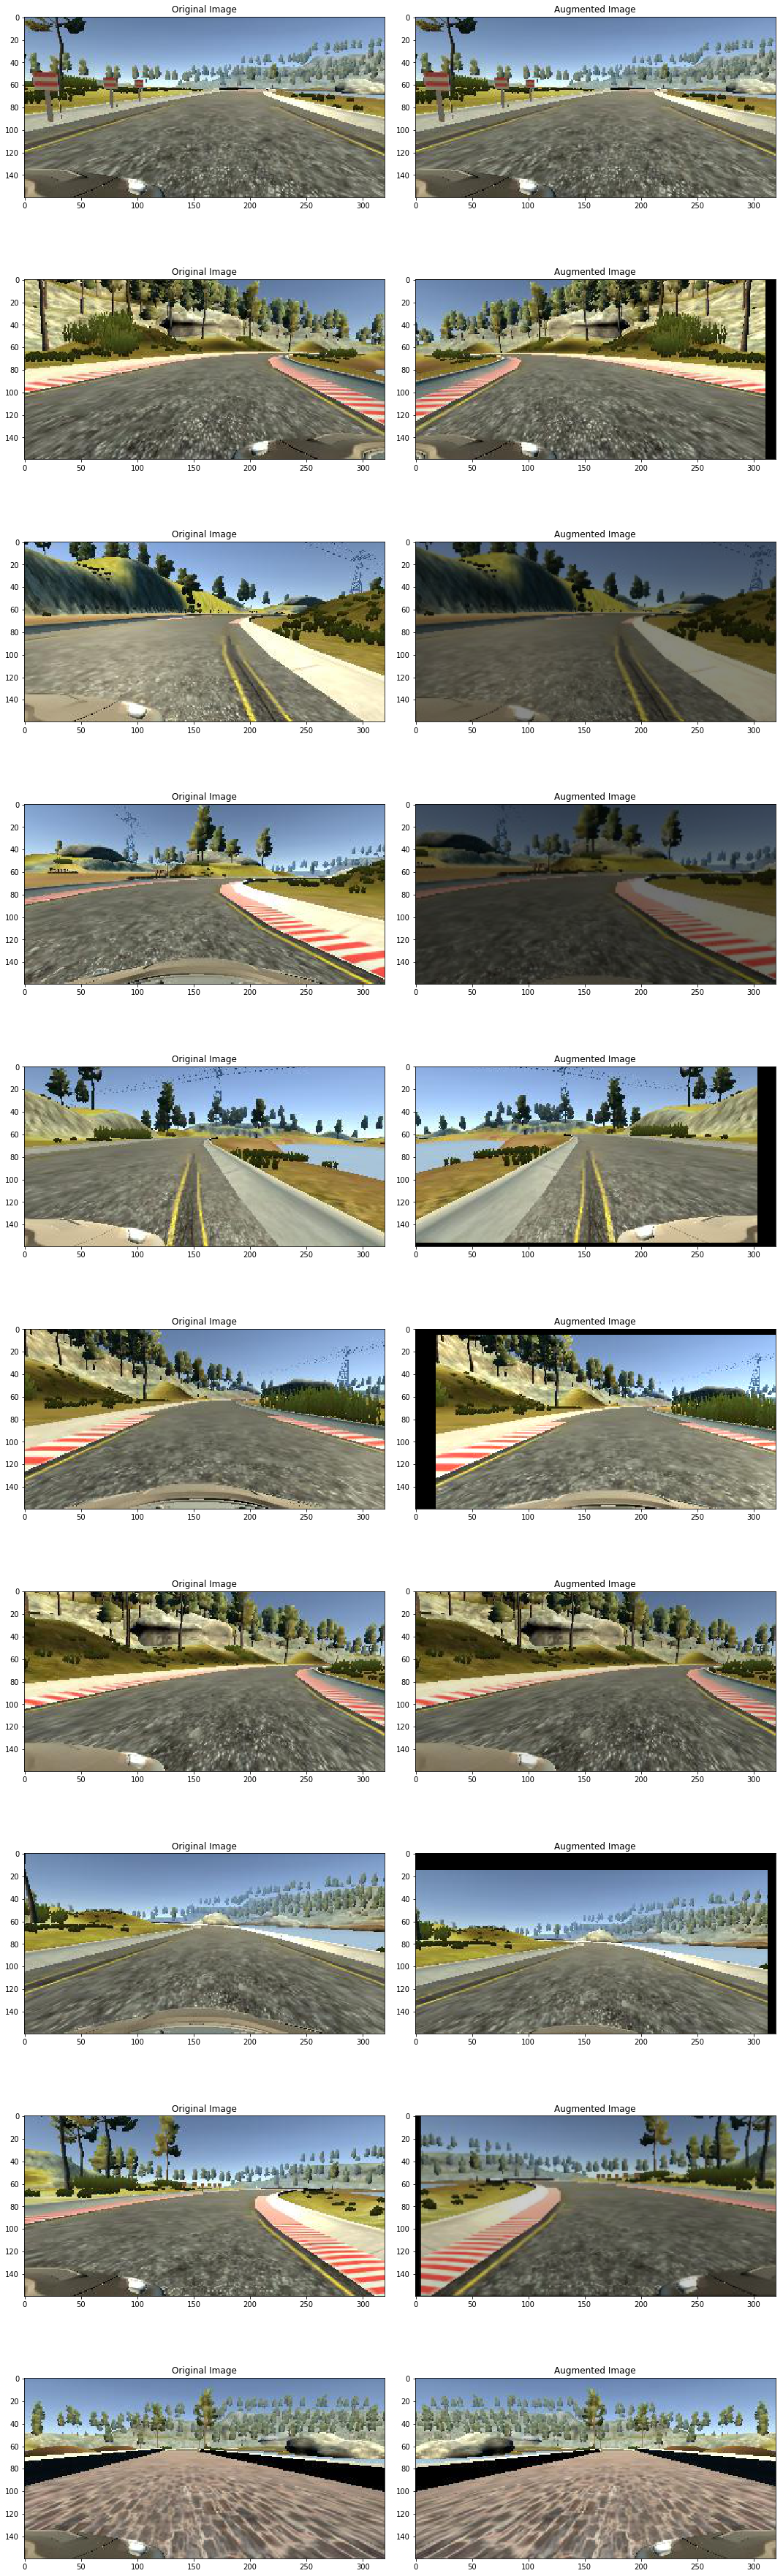

In [70]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [0]:
def img_preprocess(img, read_img = True):
  if read_img:
    img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

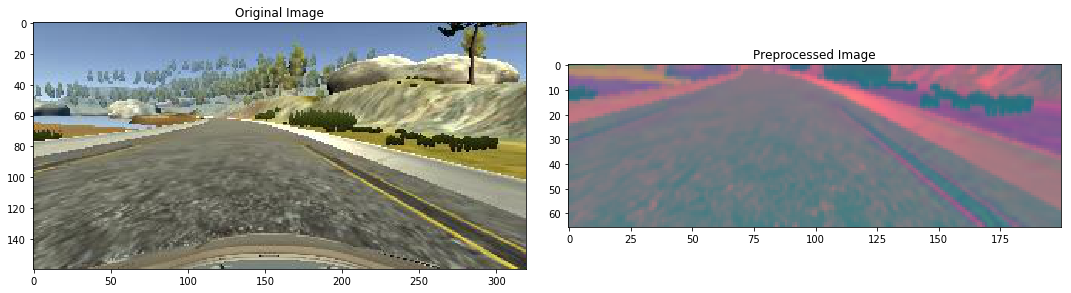

In [72]:
image = image_paths[201]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')



In [0]:
X_train_pro = np.array(list(map(img_preprocess, X_train)))
X_valid_pro = np.array(list(map(img_preprocess, X_valid)))


(4478, 66, 200, 3)


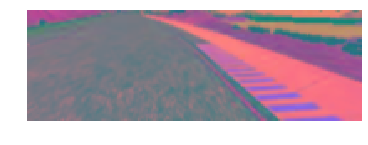

In [74]:
plt.imshow(X_train_pro[random.randint(0, len(X_train_pro)-1)])
plt.axis('off')
print(X_train_pro.shape)

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im, read_img = False)
      batch_img.append(im)
      batch_steering.append(steering)
      
    yield np.asarray(batch_img), np.asarray(batch_steering)

Text(0.5, 1.0, 'Validation Image')

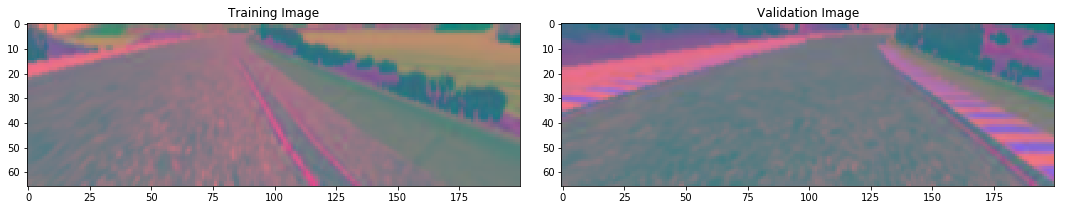

In [76]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
# x_train_gen, y_train_gen = batch_generator(X_train, y_train, 1, 1)
# x_valid_gen, y_valid_gen = batch_generator(X_valid, y_valid, 1, 0)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
def nvidia_model():
  model = Sequential()
  # using relu activation lead to dying relu problem. Gradient is zero for negative values
  model.add(Convolution2D(filters=24, kernel_size=(5,5), subsample=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(filters=36, kernel_size=(5,5), subsample=(2,2), activation='elu'))
  model.add(Convolution2D(filters=48, kernel_size=(5,5), subsample=(2,2), activation='elu'))
  model.add(Convolution2D(filters=64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(filters=64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(rate=0.25))
  
  model.add(Flatten())
  model.add(Dense(units=100, activation='elu'))
#   model.add(Dropout(rate=0.5))
  
  model.add(Dense(units=50, activation='elu'))
#   model.add(Dropout(rate=0.5))
  
  model.add(Dense(units=10, activation='elu'))
#   model.add(Dropout(rate=0.5))

  model.add(Dense(units=1))
  
  model.compile(loss='mse', optimizer=Adam(lr=1e-3))
  
  return model

In [78]:
model = nvidia_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=24, kernel_size=(5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=36, kernel_size=(5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=48, kernel_size=(5, 5), activation="elu", strides=(2, 2))`
  


In [79]:
# h = model.fit(x=X_train_pro, y=y_train, validation_data=(X_valid_pro, y_valid), batch_size=100, verbose=1, shuffle=1, epochs=15)
h = model.fit_generator(batch_generator(X_train, y_train, batch_size=100, istraining=1), 
                        validation_data=batch_generator(X_valid, y_valid, batch_size=100, istraining=0),
                        steps_per_epoch=300, 
                        validation_steps=200, 
                        verbose=1, shuffle=1, epochs=10)

Epoch 1/10
300/300 [==============================] - 150s 501ms/step - loss: 0.1632 - val_loss: 0.0956
Epoch 2/10
300/300 [==============================] - 146s 486ms/step - loss: 0.1117 - val_loss: 0.0819
Epoch 3/10
300/300 [==============================] - 146s 486ms/step - loss: 0.0995 - val_loss: 0.0822
Epoch 4/10
300/300 [==============================] - 146s 486ms/step - loss: 0.0934 - val_loss: 0.0741
Epoch 5/10
300/300 [==============================] - 143s 475ms/step - loss: 0.0915 - val_loss: 0.0698
Epoch 6/10
300/300 [==============================] - 146s 485ms/step - loss: 0.0882 - val_loss: 0.0715
Epoch 7/10
300/300 [==============================] - 146s 485ms/step - loss: 0.0841 - val_loss: 0.0692
Epoch 8/10
300/300 [==============================] - 146s 485ms/step - loss: 0.0830 - val_loss: 0.0724
Epoch 9/10
300/300 [==============================] - 145s 484ms/step - loss: 0.0825 - val_loss: 0.0697
Epoch 10/10
300/300 [==============================] - 146s 485m

Text(0.5, 0, 'Epochs')

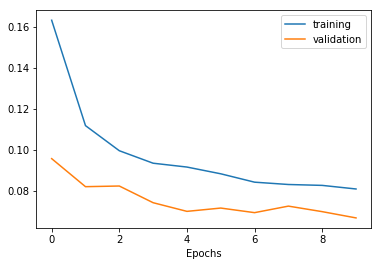

In [80]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training','validation'])
plt.xlabel('Epochs')

In [0]:
model.save('model.h5')
import time
time.sleep(5)

In [0]:
from google.colab import files
files.download('model.h5')